In [1]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72267/matrix/GSE72267_series_matrix.txt.gz

--2026-02-04 08:34:25--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72267/matrix/GSE72267_series_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.12, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7252003 (6.9M) [application/x-gzip]
Saving to: ‘GSE72267_series_matrix.txt.gz’

GSE72267_series_mat 100%[===================>]   6.92M  3.05MB/s    in 2.3s    

2026-02-04 08:34:29 (3.05 MB/s) - ‘GSE72267_series_matrix.txt.gz’ saved [7252003/7252003]



In [1]:
import pandas as pd
import numpy as np
import gzip
from io import StringIO


In [2]:
def load_geo_series_matrix(path):
    with gzip.open(path, 'rt') as f:
        lines = f.readlines()

    start, end = None, None
    for i, line in enumerate(lines):
        if line.startswith("!series_matrix_table_begin"):
            start = i + 1
        elif line.startswith("!series_matrix_table_end"):
            end = i
            break

    if start is None or end is None:
        raise ValueError("Series matrix table not found")

    data = ''.join(lines[start:end])
    df = pd.read_csv(StringIO(data), sep="\t", index_col=0)
    return df


In [3]:
path = "/workspaces/Reasearch_Genomic/GSE72267_series_matrix.txt.gz"

df = load_geo_series_matrix(path)
print("Original shape:", df.shape)


Original shape: (22277, 59)


In [4]:
X = df.T
print("After transpose:", X.shape)


After transpose: (59, 22277)


In [5]:
y = np.zeros(X.shape[0])
y[: X.shape[0] // 2] = 1


In [6]:
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(0)

print(X.dtypes.unique())


[dtype('float64')]


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=5000,
    C=1.0
)

lasso.fit(X_scaled, y)


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l1'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass`

In [9]:
coef = lasso.coef_[0]
importance = np.abs(coef)
genes = X.columns.to_numpy()

lasso_df = pd.DataFrame({
    "Gene": genes,
    "Coefficient": coef,
    "Importance": importance
})


In [10]:
top_32 = (
    lasso_df[lasso_df["Importance"] > 0]
    .sort_values(by="Importance", ascending=False)
    .head(32)
)

top_32


,Gene,Coefficient,Importance
20269,220906_at,-0.108889,0.108889
5907,206382_s_at,-0.091542,0.091542
17321,217957_at,0.091515,0.091515
20000,220637_at,0.083304,0.083304
9813,210335_at,0.075121,0.075121
5968,206443_at,-0.075077,0.075077
4868,205342_s_at,0.074406,0.074406
7606,208098_at,-0.073899,0.073899
20027,220664_at,0.073893,0.073893
15241,215869_at,-0.070586,0.070586


In [11]:
top_32.to_csv("GSE72267_Top32_LASSO.csv", index=False)
print("Saved: GSE72267_Top32_LASSO.csv")


Saved: GSE72267_Top32_LASSO.csv


In [12]:
selected_genes = top_32["Gene"].values
X_lasso = X[selected_genes]


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_lasso,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss


In [16]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    batch_size=16,
    learning_rate_init=0.001,
    max_iter=1,
    warm_start=True,
    random_state=42
)


In [17]:
epochs = 50

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for _ in range(epochs):
    mlp.fit(X_train_scaled, y_train)

    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_val_scaled)

    y_train_prob = mlp.predict_proba(X_train_scaled)
    y_val_prob = mlp.predict_proba(X_val_scaled)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_val, y_val_prob))


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3

In [18]:
print(f"Training Accuracy: {train_acc[-1]:.4f}")
print(f"Validation Accuracy: {val_acc[-1]:.4f}")


Training Accuracy: 1.0000
Validation Accuracy: 1.0000


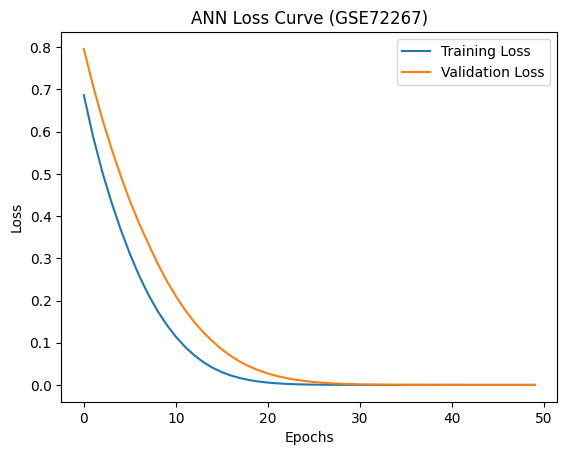

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Loss Curve (GSE72267)")
plt.legend()
plt.show()


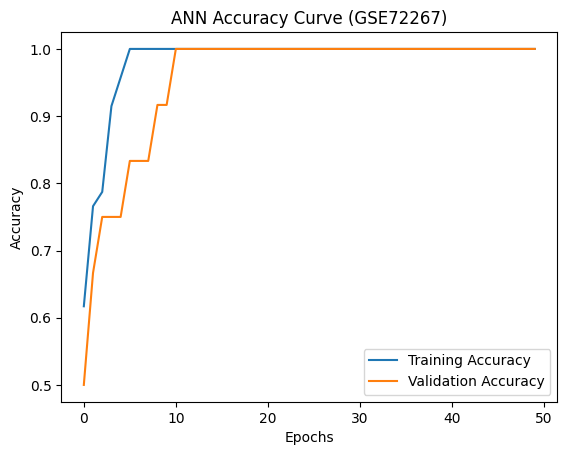

In [20]:
plt.figure()
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ANN Accuracy Curve (GSE72267)")
plt.legend()
plt.show()
